<a href="https://colab.research.google.com/github/wanlong-peng/Colab/blob/main/tfdata_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#使用 tf.data 和 TensorFlow 的数据管道
- 如何使用 TensorFlow 函数高效加载图像？
- 如何使用 TensorFlow 函数从文件路径解析类标签？
- 什么是 @tf.function 装饰器以及它如何用于数据加载和预处理？
- 我如何初始化三个独立的 数据 管道，分别用于训练、验证和测试？
- 最重要的是，我如何使用数据 管道？


##1.tf.data 还是 ImageDataGenerator 更适合使用 TensorFlow 构建数据管道？

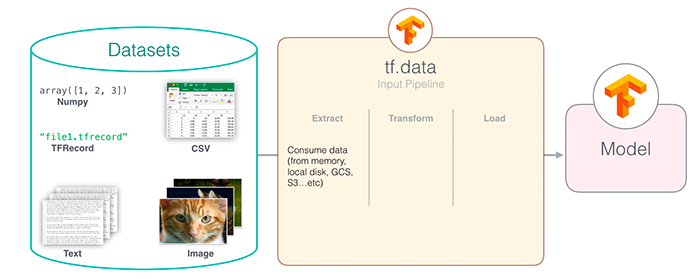

    图 1：使用“tf.data”构建数据生成管道往往比“ImageDataGenerator”（图像源）快得多。

就像计算机科学中的许多复杂问题一样，这个问题的答案是“这取决于”。

这 ImageDataGenerator类文档齐全，易于使用，并且直接嵌入在 Keras API 中（如果您有兴趣，我有一个关于使用 ImageDataGenerator 进行数据增强的教程）。

这 .data 另一方面，模块是一个较新的实现，旨在将类似 PyTorch 的数据加载和处理引入 TensorFlow 库。

在创建数据管道时 tf.data 确实需要更多的工作，获得的加速值得如此做。

正如我上周演示的那样，使用数据导致数据生成速度提升约 38 倍。如果您需要纯粹的速度，并愿意写20-30多行代码（取决于多么先进，你想要得到），这是非常值得的额外的前期时间来实现数据 管道。

In [ ]:
#!pip install tensorflow==2.4.0

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/tfdata-pipelines/tfdata-pipelines.zip
!unzip -qq tfdata-pipelines.zip
%cd tfdata-pipelines

--2021-06-22 13:26:35--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/tfdata-pipelines/tfdata-pipelines.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.218.133.34
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.218.133.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46749 (46K) [application/zip]
Saving to: ‘tfdata-pipelines.zip’

tfdata-pipelines.zi 100%[===================>]  45.65K  --.-KB/s    in 0.1s    

2021-06-22 13:26:36 (341 KB/s) - ‘tfdata-pipelines.zip’ saved [46749/46749]

/content/tfdata-pipelines


### Downloading the dataset

Since this dataset is hosted on Kaggle, we have a few options to get the dataset from Kaggle to our Colab Notebook environment - 

* Download the dataset from Kaggle as a zipped file, upload that to our Google Drive, and then mount Google Drive on Colab to access the uploaded dataset. 
* Use the [Kaggle API](https://github.com/Kaggle/kaggle-api) to directly download the dataset to our Colab Notebook environment. 

We will be using the second option. **Note** that you need to obtain your Kaggle API keys to perform this step. Follow the instructions [here](https://github.com/Kaggle/kaggle-api) in order to obtain your Kaggle API keys in case you don't have them. 

Now, navigate to File Browser of Colab and upload your keys following [this screencast](https://www.loom.com/share/ca76bb983e0844e2a7f14b473d7287c6). After the keys file has been uploaded, we need to move it to an appropriate location. 

In [6]:
# !cd ~
# !pwd

/content/tfdata-pipelines


In [8]:
!cd ~/.kaggle
/content/drive/MyDrive/kaggle .json

In [14]:
#!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, we can download the dataset. 

In [16]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.10G/3.10G [01:09<00:00, 62.4MB/s]



To follow along with the rest of the code, please move the download dataset by executing the command below. 

In [17]:
!mkdir datasets/orig
!mv breast-histopathology-images.zip datasets/orig/
%cd datasets/orig/
!unzip -qq breast-histopathology-images.zip -x "IDC_regular_ps50_idx5/*"
%cd /content/tfdata-pipelines

/content/tfdata-pipelines/datasets/orig
[Errno 2] No such file or directory: '/content/tdata-pipelines'
/content/tfdata-pipelines/datasets/orig


In [20]:
!pwd
%cd /content/tfdata-pipelines

/content/tfdata-pipelines/datasets/orig
/content/tfdata-pipelines


## Blog Post Code

### Import Packages

In [21]:
# import the necessary packages
from pyimagesearch.cancernet import CancerNet
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from matplotlib import pyplot as plt
from imutils import paths
import tensorflow as tf
import random
import shutil
import os

### Function to display images in Jupyter Notebooks and Google Colab

In [22]:
def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()

### Creating our configuration file

In [25]:
class Config:
    # import the necessary packages
    import os

    # 初始化图像的*原始*输入目录的路径
    ORIG_INPUT_DATASET = os.path.join("datasets", "orig")
    #将目录和文件名合成一个路径 datasets/orig

    # 初始化将包含的 *new* 目录的基本路径 
    # 计算训练和测试分割后的图像
    BASE_PATH = os.path.join("datasets", "idc")
    #os.path.join()该函数传入的参数是多个字符串型变量

    # 派生训练、验证和测试目录
    TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])#返回BASE_PATH/training
    VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
    TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
    # os.sep是为了解决不同平台上文件路径分隔符差异问题，例如在windows平台上，路径分隔符为：‘\’；
    # Linux平台上为：‘/’；MAC上是‘:’。那么当在不同的平台上使用os.sep时，对应的路径分隔符就分别是以上列举的几种。
    # os.sep.join( )函数传入的参数是一个列表，输出的结果是将列表中的元素用相应平台对应的路径分隔符链接起来的整体


    # define the amount of data that will be used training
    TRAIN_SPLIT = 0.8

    # the amount of validation data will be a percentage of the
    # *training* data
    VAL_SPLIT = 0.1

    # define input image spatial（空间尺寸） dimensions
    IMAGE_SIZE = (48, 48)

    # initialize our number of epochs, early stopping patience, initial
    # learning rate, and batch size
    NUM_EPOCHS = 40
    EARLY_STOPPING_PATIENCE = 5
    INIT_LR = 1e-2
    BS = 128

# 实例化一个配置对象
config = Config()

In [ ]:
!cp /content/drive/MyDrive/testPicture/IMG_4759.JPG /content/sample_data
!cp /content/drive/MyDrive/testPicture/v2-7dd9f8ba2af02b0a5f996f816e780e19_720w.jpg /content/sample_data
import os
os.listdir('/content/sample_data/')
#列出路径下的文件名或图片名并且存入list列表

In [39]:
!cp /content/drive/MyDrive/testPicture/IMG_4759.JPG /content/sample_data
!cp /content/drive/MyDrive/testPicture/IMG_4764.JPG /content/sample_data
!cp /content/drive/MyDrive/testPicture/IMG_4762.JPG /content/sample_data
from imutils import paths
#list(paths.list_images('/content/sample_data/'))
test_path=list(paths.list_images('/content/sample_data/'))#该方法只返回对应路径下图片名
print(test_path)

['/content/sample_data/IMG_4759.JPG', '/content/sample_data/IMG_4762.JPG', '/content/sample_data/IMG_4764.JPG']


In [43]:
for x in test_path:
  test_filename = x.split(os.path.sep)[-1]
  print(test_filename)
  test_labels = test_filename[-6:-5]
  print(test_labels)

IMG_4759.JPG
5
IMG_4762.JPG
6
IMG_4764.JPG
6


4


### Implementing our dataset organizer on disk

In [27]:
# 获取原始输入目录中所有输入图像的路径 
# 并将它们洗牌打乱顺序
imagePaths = list(paths.list_images(config.ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)

# compute the training and testing split
#图片路径列表的长度即为图片总数，图片总数×0.8=%80比例的训练集
i = int(len(imagePaths) * config.TRAIN_SPLIT)
#取出总数百分之80比例下的个数的图片路径，即0~0.8×图片总数
trainPaths = imagePaths[:i]
#后百分之20的图片路径作为测试集
testPaths = imagePaths[i:]

# 取出训练集中的一部分作为验证集
# 训练集图片总数的0.1作为测试集
i = int(len(trainPaths) * config.VAL_SPLIT)
# 验证路径即为训练总数的前0.1
valPaths = trainPaths[:i]
# 训练总数的0.1~1留作训练集
trainPaths = trainPaths[i:]

# 构建我们的数据集
datasets = [
	("training", trainPaths, config.TRAIN_PATH),
	("validation", valPaths, config.VAL_PATH),
	("testing", testPaths, config.TEST_PATH)
]

In [28]:
# 循环遍历数据集
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))

	# 如果没有输出路径，便创建它，比如没有对应的训练、测试、验证路径，就创建该路径
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)

	# 遍历输入图片路径
	for inputPath in imagePaths:
		# 提取输入图片文件名，提取类标签
		# class label ("0" for "negative" and "1" for "positive")
		filename = inputPath.split(os.path.sep)[-1]
		label = filename[-5:-4]

		# 建立标签路径
		labelPath = os.path.sep.join([baseOutput, label])

		# 若标签路径不存在，创建它
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)

    # 构造目标图像的路径，然后复制源图像到目标路径
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)
    # shutil.copy2()Python中的方法用于将源文件的内容复制到目标文件或目录。
    # 此方法与shutil.copy()方法，但它还会尝试保留文件的元数据。
    # 源必须代表文件，但目标可以是文件或目录。如果目标是目录，
    # 则文件将使用源中的基本文件名复制到目标中。另外，目的地必须是可写的。
    # 如果目标是文件并且已经存在，则将其替换为源文件，否则将创建一个新文件。

[INFO] building 'training' split
[INFO] 'creating datasets/idc/training' directory
[INFO] 'creating datasets/idc/training/1' directory
[INFO] 'creating datasets/idc/training/0' directory
[INFO] building 'validation' split
[INFO] 'creating datasets/idc/validation' directory
[INFO] 'creating datasets/idc/validation/0' directory
[INFO] 'creating datasets/idc/validation/1' directory
[INFO] building 'testing' split
[INFO] 'creating datasets/idc/testing' directory
[INFO] 'creating datasets/idc/testing/0' directory
[INFO] 'creating datasets/idc/testing/1' directory


### Implementing our training script using tf.data and TensorFlow data pipelines

In [29]:
def load_images(imagePath):
  # 从磁盘读取图像，解码，将数据类型转换为浮点数，并调整大小
	image = tf.io.read_file(imagePath)
	image = tf.image.decode_png(image, channels=3)
	image = tf.image.convert_image_dtype(image, dtype=tf.float32)
	image = tf.image.resize(image, config.IMAGE_SIZE)

	# 从文件路径解析类标签
	label = tf.strings.split(imagePath, os.path.sep)[-2]
	label = tf.strings.to_number(label, tf.int32)
	
	# 返回图像和标签
	return (image, label)

In [30]:
@tf.function
def augment(image, label):
	# 执行随机水平和垂直翻转
	image = tf.image.random_flip_up_down(image)
	image = tf.image.random_flip_left_right(image)

	# 返回图像和标签
	return (image, label)

In [31]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output loss/accuracy plot")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"plot": "plot.png"
}

In [32]:
# 获取所有训练、验证和测试数据集图像路径
trainPaths = list(paths.list_images(config.TRAIN_PATH))
valPaths = list(paths.list_images(config.VAL_PATH))
testPaths = list(paths.list_images(config.TEST_PATH))

# 计算每个类中训练图像的总数和

trainLabels = [int(p.split(os.path.sep)[-2]) for p in trainPaths]
trainLabels = to_categorical(trainLabels)#转换独热编码
classTotals = trainLabels.sum(axis=0)

# 初始化一个字典来存储类权重
classWeight = {}

# 历所有类并计算类权重
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

In [33]:
# 构建训练集和数据输入管道
trainDS = tf.data.Dataset.from_tensor_slices(trainPaths)
trainDS = (trainDS
	.shuffle(len(trainPaths))
	.map(load_images, num_parallel_calls=AUTOTUNE)
	.map(augment, num_parallel_calls=AUTOTUNE)
	.cache()
	.batch(config.BS)
	.prefetch(AUTOTUNE)
)
# 我们首先创建一个实例 tf.data.Dataset 使用 from_tensor_slices函数

# 这 tf.data 管道本身包括以下步骤：

# 打乱训练集中的所有图像路径
# 在缓冲区中加载图像
# 对加载的图像执行数据增强
# 缓存结果以供后续更快的读取
# 创建一批数据
# 允许 预取 在后台优化例程

In [34]:
# 构建验证集和数据输入管道
valDS = tf.data.Dataset.from_tensor_slices(valPaths)
valDS = (valDS
	.map(load_images, num_parallel_calls=AUTOTUNE)
	.cache()
	.batch(config.BS)
	.prefetch(AUTOTUNE)
)

# 构建测试集和数据输入管道
testDS = tf.data.Dataset.from_tensor_slices(testPaths)
testDS = (testDS
	.map(load_images, num_parallel_calls=AUTOTUNE)
	.cache()
	.batch(config.BS)
	.prefetch(AUTOTUNE)
)

In [35]:
# 初始化乳腺癌网络模型并编译
model = CancerNet.build(width=48, height=48, depth=3,
	classes=1)
opt = Adagrad(lr=config.INIT_LR,
	decay=config.INIT_LR / config.NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
# 初始化一个提前停止回调以防止模型过拟合
es = EarlyStopping(
	monitor="val_loss",
	patience=config.EARLY_STOPPING_PATIENCE,
	restore_best_weights=True)

# fit the model
H = model.fit(
	x=trainDS,
	validation_data=valDS,
	class_weight=classWeight,
	epochs=config.NUM_EPOCHS,
	callbacks=[es],
	verbose=1)

# evaluate the model on test set
(_, acc) = model.evaluate(testDS)
print("[INFO] test accuracy: {:.2f}%...".format(acc * 100))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/40
1562/1562 [==============================] - 255s 144ms/step - loss: 0.5894 - accuracy: 0.8190 - val_loss: 0.7399 - val_accuracy: 0.6552
Epoch 2/40
1562/1562 [==============================] - 126s 81ms/step - loss: 0.5328 - accuracy: 0.8393 - val_loss: 0.6738 - val_accuracy: 0.6919
Epoch 3/40
1562/1562 [==============================] - 126s 81ms/step - loss: 0.5204 - accuracy: 0.8437 - val_loss: 0.6737 - val_accuracy: 0.6958
Epoch 4/40
1562/1562 [==============================] - 125s 80ms/step - loss: 0.5135 - accuracy: 0.8458 - val_loss: 0.6294 - val_accuracy: 0.7156
Epoch 5/40
1562/1562 [==============================] - 125s 80ms/step - loss: 0.5097 - accuracy: 0.8472 - val_loss: 0.5932 - val_accuracy: 0.7313
Epoch 6/40
1562/1562 [==============================] - 127s 81ms/step - loss: 0.5062 - accuracy: 0.8484 - val_loss: 0.5497 - 

In [ ]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Data pipelines with tf.data and TensorFlow*](https://www.pyimagesearch.com/2021/06/21/data-pipelines-with-tf-data-and-tensorflow/) published on 2021-06-21.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```